# 모델 학습

## 학습 데이터셋 - angry_train_img, happy_train_img

In [ ]:
import zipfile
zip_file = zipfile.ZipFile('/content/angry_train_img.zip')
zip_file.extractall('/content/')

In [ ]:
zip_file = zipfile.ZipFile('/content/happy_train_img.zip')
zip_file.extractall('/content/')

In [ ]:
import os
import pandas as pd

happy_folder = '/content/happy_train_img'
angry_folder = '/content/angry_train_img'

# happy 폴더의 파일 경로와 레이블 생성
happy_files = [{'filename': os.path.join(happy_folder, file), 'label': 'happy'}
               for file in os.listdir(happy_folder) if os.path.isfile(os.path.join(happy_folder, file))]

# angry 폴더의 파일 경로와 레이블 생성
angry_files = [{'filename': os.path.join(angry_folder, file), 'label': 'angry'}
               for file in os.listdir(angry_folder) if os.path.isfile(os.path.join(angry_folder, file))]

# 두 데이터를 합쳐 DataFrame 생성
data = happy_files + angry_files
df = pd.DataFrame(data)

print(df.head())
print(f"DataFrame 크기: {df.shape}")


                                            filename  label
0  /content/happy_train_img/mbgf2cW2UYc8NJK3IrfsA...  happy
1    /content/happy_train_img/happy_dog_7_crop_1.jpg  happy
2  /content/happy_train_img/happy_dog_883_crop_1.jpg  happy
3  /content/happy_train_img/jJBxoIxwlVNgGSaBcMVp1...  happy
4  /content/happy_train_img/happy_dog_707_crop_1.jpg  happy
DataFrame 크기: (1000, 2)


In [ ]:
df.tail()

,filename,label
995,/content/angry_train_img/qn15HlNdy8PMqOBqVbATk...,angry
996,/content/angry_train_img/iGlC3SeXCm67ryHPOdyVT...,angry
997,/content/angry_train_img/DOmjof3ST9DvaIDxpG2bP...,angry
998,/content/angry_train_img/LVkN2kvRzF5DmF40ZbJ6Q...,angry
999,/content/angry_train_img/tUTwULjZiS8CR3eZD8qIz...,angry


### label one-hot encoding

In [ ]:
label_mapping = {'happy': 0, 'angry': 1}
df['label'] = df['label'].replace(label_mapping)

df.head()

<ipython-input-5-5378fd6b68c3>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['label'] = df['label'].replace(label_mapping)


,filename,label
0,/content/happy_train_img/mbgf2cW2UYc8NJK3IrfsA...,0
1,/content/happy_train_img/happy_dog_7_crop_1.jpg,0
2,/content/happy_train_img/happy_dog_883_crop_1.jpg,0
3,/content/happy_train_img/jJBxoIxwlVNgGSaBcMVp1...,0
4,/content/happy_train_img/happy_dog_707_crop_1.jpg,0


### data augemtation

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
    A.Resize(224, 224),
    A.OneOf([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5)
    ], p=0.5),
    A.OneOf([
        A.GaussianBlur(blur_limit=(3, 7), p=0.5),
        A.MotionBlur(blur_limit=7, p=0.5),
        A.MedianBlur(blur_limit=7, p=0.5)
    ], p=0.5),
    A.CoarseDropout(max_holes=8, max_height=16, max_width=16, p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2()
])

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
from glob import glob
import os

def get_train_data():
    img_path_list = []
    label_list = []

    img_path_list.extend(df['filename'])
    label_list.extend(df['label'])
    return img_path_list, label_list

all_img_path, all_label = get_train_data()

print(all_img_path[:10])
print(all_label[:10])

['/content/happy_train_img/mbgf2cW2UYc8NJK3IrfsAT7Ae8x8YV635_crop_1.jpg', '/content/happy_train_img/happy_dog_7_crop_1.jpg', '/content/happy_train_img/happy_dog_883_crop_1.jpg', '/content/happy_train_img/jJBxoIxwlVNgGSaBcMVp1UoJ2tuu07944_crop_1.jpg', '/content/happy_train_img/happy_dog_707_crop_1.jpg', '/content/happy_train_img/happy_dog_843_crop_1.jpg', '/content/happy_train_img/fASHRePhtrxPPSrrBUPgngUPoVxBLT450_crop_1.jpg', '/content/happy_train_img/ALtNe7EsD5vihMWy77wOpPZDZeeW6L609_crop_1.jpg', '/content/happy_train_img/dog_31_crop_1.jpg', '/content/happy_train_img/dog_101_crop_1.jpg']
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


### CustomDataset 정의

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2


class CustomDataset(Dataset):
    def __init__(self, img_paths, labels=None, transform=None):
        self.img_paths = img_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        if self.labels is not None:
            label = torch.tensor(self.labels[idx], dtype=torch.long)  # 레이블을 PyTorch 텐서로 변환
            return image, label
        else:
            return image


# stratify = all_label: label 0과 1의 비율이 train과 valid에서도 유지
train_img_paths, val_img_paths, train_labels, val_labels = train_test_split(all_img_path, all_label, test_size=0.2, random_state=42,stratify=all_label)

train_dataset = CustomDataset(train_img_paths, train_labels, transform=train_transform)
val_dataset = CustomDataset(val_img_paths, val_labels, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [ ]:
from collections import Counter

train_label_counts = Counter(train_labels)
val_label_counts = Counter(val_labels)

print("Train Labels Distribution:")
print(train_label_counts)

print("\nValidation Labels Distribution:")
print(val_label_counts)


Train Labels Distribution:
Counter({1: 400, 0: 400})

Validation Labels Distribution:
Counter({1: 100, 0: 100})


### resnet18 로드

In [ ]:
import torch
from torchvision import models

model = models.resnet18(pretrained=True)
#print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 63.7MB/s]


### train(), validate()

In [ ]:
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train(model, criterion, optimizer, train_loader):
    model.train()
    running_loss = 0.0
    corrects = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.long().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, preds = torch.max(outputs, 1)  
        corrects += torch.sum(preds == labels)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = corrects.double() / len(train_loader.dataset)
    return epoch_loss, epoch_acc

def validate(model, criterion, val_loader):
    model.eval()
    val_loss = 0.0
    val_corrects = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images, labels = images.to(device), labels.long().to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels)

    epoch_loss = val_loss / len(val_loader)
    epoch_acc = val_corrects.double() / len(val_loader.dataset)
    return epoch_loss, epoch_acc


### layer 4 이전의 파라미터는 freeze

In [ ]:
import torch.nn as nn
import torch.optim as optim

for param in model.parameters():
    param.requires_grad = False

# layer4와 fc layer 학습
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

# fc 레이어 수정 (클래스 개수에 맞게 변경)
num_classes = 2  # happy와 angry
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

print("학습 가능한 파라미터:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

학습 가능한 파라미터:
layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.weight
layer4.0.bn2.weight
layer4.0.bn2.bias
layer4.0.downsample.0.weight
layer4.0.downsample.1.weight
layer4.0.downsample.1.bias
layer4.1.conv1.weight
layer4.1.bn1.weight
layer4.1.bn1.bias
layer4.1.conv2.weight
layer4.1.bn2.weight
layer4.1.bn2.bias
fc.weight
fc.bias


### 모델 학습 및 검증

100%|██████████| 13/13 [00:19<00:00,  1.50s/it]


Epoch 1/50, Train Loss: 0.5091, Train Accuracy: 0.7250, Validation Loss: 0.3291, Validation Accuracy: 0.8650


100%|██████████| 13/13 [00:18<00:00,  1.39s/it]


Epoch 2/50, Train Loss: 0.2958, Train Accuracy: 0.8725, Validation Loss: 0.2518, Validation Accuracy: 0.8800


100%|██████████| 13/13 [00:19<00:00,  1.50s/it]


Epoch 3/50, Train Loss: 0.2201, Train Accuracy: 0.9100, Validation Loss: 0.3056, Validation Accuracy: 0.8800


100%|██████████| 13/13 [00:17<00:00,  1.38s/it]


Epoch 4/50, Train Loss: 0.2024, Train Accuracy: 0.9150, Validation Loss: 0.2395, Validation Accuracy: 0.8850


100%|██████████| 13/13 [00:19<00:00,  1.48s/it]


Epoch 5/50, Train Loss: 0.2106, Train Accuracy: 0.9137, Validation Loss: 0.2462, Validation Accuracy: 0.9150


100%|██████████| 13/13 [00:18<00:00,  1.39s/it]


Epoch 6/50, Train Loss: 0.1864, Train Accuracy: 0.9313, Validation Loss: 0.1397, Validation Accuracy: 0.9300


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 7/50, Train Loss: 0.1490, Train Accuracy: 0.9363, Validation Loss: 0.2074, Validation Accuracy: 0.9050


100%|██████████| 13/13 [00:18<00:00,  1.39s/it]


Epoch 8/50, Train Loss: 0.0984, Train Accuracy: 0.9575, Validation Loss: 0.1934, Validation Accuracy: 0.9200


100%|██████████| 13/13 [00:18<00:00,  1.46s/it]


Epoch 9/50, Train Loss: 0.1242, Train Accuracy: 0.9550, Validation Loss: 0.1440, Validation Accuracy: 0.9300


100%|██████████| 13/13 [00:18<00:00,  1.45s/it]


Epoch 10/50, Train Loss: 0.1548, Train Accuracy: 0.9325, Validation Loss: 0.2726, Validation Accuracy: 0.9100


100%|██████████| 13/13 [00:19<00:00,  1.48s/it]


Epoch 11/50, Train Loss: 0.1020, Train Accuracy: 0.9600, Validation Loss: 0.2105, Validation Accuracy: 0.9100
Early stopping triggered.


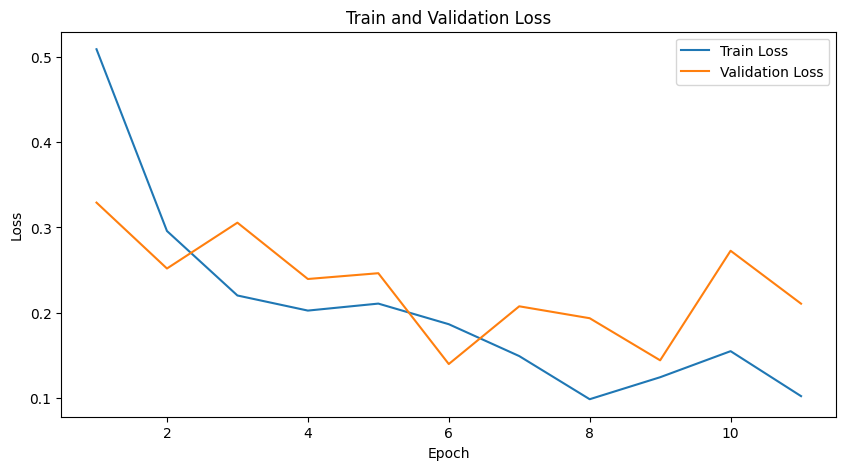

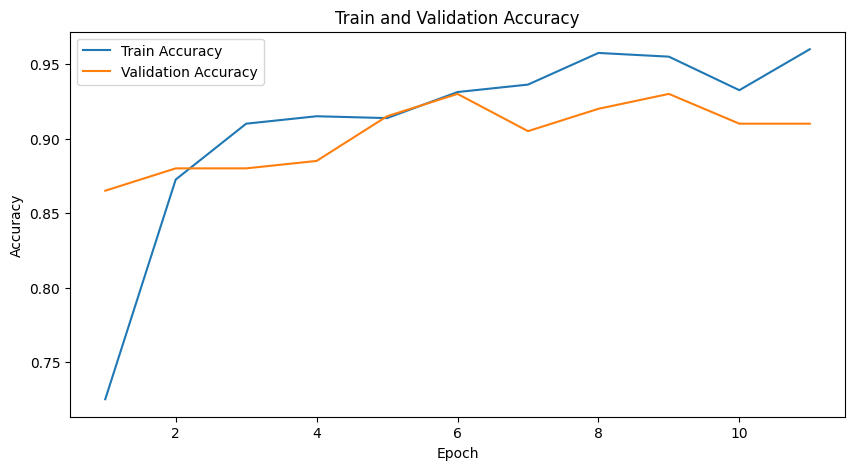

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

num_epochs = 50
patience = 5 
best_val_loss = float('inf') 
early_stop_counter = 0  

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, criterion, optimizer, train_loader)
    val_loss, val_acc = validate(model, criterion, val_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc.item())
    val_losses.append(val_loss)
    val_accuracies.append(val_acc.item())

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, "
          f"Train Accuracy: {train_acc:.4f}, "
          f"Validation Loss: {val_loss:.4f}, "
          f"Validation Accuracy: {val_acc:.4f}")

    # Early Stopping Check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0 
    else:
        early_stop_counter += 1 

    if early_stop_counter >= patience:
        print("Early stopping triggered.")
        break

# train, valid loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# train, valid accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
import torch

torch.save(model.state_dict(), "model_weights.pth")

# 모델 load해서 test

In [ ]:
from torchvision import models
import torch.nn as nn
import torch

model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

num_classes = 2 
model.fc = nn.Linear(model.fc.in_features, num_classes)

model.load_state_dict(torch.load("model_weights.pth"))
model.eval()

<ipython-input-16-1ae7d87c8f59>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model_weights.pth"))


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
for name, param in model.named_parameters():
    print(f"Layer: {name} | Requires Grad: {param.requires_grad}")


Layer: conv1.weight | Requires Grad: False
Layer: bn1.weight | Requires Grad: False
Layer: bn1.bias | Requires Grad: False
Layer: layer1.0.conv1.weight | Requires Grad: False
Layer: layer1.0.bn1.weight | Requires Grad: False
Layer: layer1.0.bn1.bias | Requires Grad: False
Layer: layer1.0.conv2.weight | Requires Grad: False
Layer: layer1.0.bn2.weight | Requires Grad: False
Layer: layer1.0.bn2.bias | Requires Grad: False
Layer: layer1.1.conv1.weight | Requires Grad: False
Layer: layer1.1.bn1.weight | Requires Grad: False
Layer: layer1.1.bn1.bias | Requires Grad: False
Layer: layer1.1.conv2.weight | Requires Grad: False
Layer: layer1.1.bn2.weight | Requires Grad: False
Layer: layer1.1.bn2.bias | Requires Grad: False
Layer: layer2.0.conv1.weight | Requires Grad: False
Layer: layer2.0.bn1.weight | Requires Grad: False
Layer: layer2.0.bn1.bias | Requires Grad: False
Layer: layer2.0.conv2.weight | Requires Grad: False
Layer: layer2.0.bn2.weight | Requires Grad: False
Layer: layer2.0.bn2.bias 

# 모델 평가

In [ ]:
from PIL import Image
import cv2
import torch

model.eval()

image_path = "/content/KakaoTalk_20241119_205843305_04.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

transformed = test_transform(image=image)
input_tensor = transformed["image"].unsqueeze(0)  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_tensor = input_tensor.to(device)
with torch.no_grad():
    outputs = model(input_tensor)
    _, predicted_class = torch.max(outputs, 1)

label_mapping = {0: "happy", 1: "angry"}
predicted_label = label_mapping[predicted_class.item()]

print(f"분류 결과: {predicted_label}")

분류 결과: happy
